<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/15_6_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

In [3]:
#transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values

In [4]:
# difference dataset
def difference(data, order):
  return [data[i] - data[i - order] for i in range(order, len(data))]

In [5]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, n_diff = config
  # prepare data
  if n_diff > 0:
    train = difference(train, n_diff)
  # transform series into supervised format
  data = series_to_supervised(train, n_in=n_input)
  # separate inputs and outputs
  train_x, train_y = data[:, :-1], data[:, -1]
  # reshape input data into [samples, timesteps, features]
  n_features = 1
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit model
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [6]:
# forecast with the fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _, n_diff = config
  # prepare data
  correction = 0.0
  if n_diff > 0:
    correction = history[-n_diff]

  history = difference(history, n_diff)
  # reshape sample into [samples, timesteps, features]
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)

  return abs(correction + yhat[0])

In [7]:
# make predictions on test data
def make_predictions(train, test, model, cfg):
  predictions = list()
  
  # seed history with training dataset
  history = [x for x in train]

  # step over each time-step in the test set
  for i in range(len(test)):
    
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat[0])
    # add predicted observation to history for the next loop
    history.append(yhat)


  return predictions

Read dataset

In [8]:
df = read_csv('/content/RevenueJuly.csv')
series = DataFrame(df['Revenue'])

In [9]:
series

,Revenue
0,11141.566
1,11483.520
2,89026.192
3,7486.732
4,17719.978
5,159129.659
6,16736.302
7,25432.066
8,145620.785
9,24954.743


In [10]:
data = series.values

In [11]:
#perform train-test split
n_test = 7
train , test = train_test_split(data,n_test)

In [12]:
train.shape , test.shape

((48, 1), (7, 1))

In [13]:
#define model configuration
n_input = 4
n_nodes = 50
n_epochs = 20
n_batch = 12
n_diff = 12
config = [n_input, n_nodes, n_epochs, n_batch, n_diff]

In [14]:
# build and fit model
model = model_fit(train, config)

In [15]:
# make predictions
predictions = make_predictions(train, test, model, config)

In [16]:
#Evaluate Model using r2_score and RMSE
MSE = mean_squared_error(test, predictions)
RMSE = int(sqrt(MSE))
R2 = r2_score(test,predictions)
print('RMSE : ' + str(RMSE))
print('R square : ' + str(R2))

RMSE : 33591
R square : 0.6524652445915203


In [17]:
predictions

[1927.3512656249986,
 11750.563714843753,
 97573.162984375,
 15456.143951171875,
 26116.99523828125,
 225433.05104296876,
 24860.003607910156]

In [18]:
test

array([[ 16507.335],
       [ 55265.293],
       [132267.597],
       [ 20550.787],
       [ 45757.982],
       [183715.237],
       [ 74225.599]])

Add Graph

In [19]:
#set x axis labels
vis = dict()

x_axis_label = []

for cur_year in df['Year']:
  if str(cur_year) not in vis.keys():
    vis[str(cur_year)] = 1
    x_axis_label.append(str(cur_year))
  
  else:
    x_axis_label.append('')
  

In [20]:
x_axis_label

['2017',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2018',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2019',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2020',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '2021',
 '',
 '',
 '',
 '',
 '',
 '']

Specify dates

In [21]:
dates_train = []
for i in range(len(df)-n_test):
  dates_train.append( str(df['Year'][i]) + "-" + str(df['Month'][i]) )

dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2017-5',
 '2017-6',
 '2017-7',
 '2017-8',
 '2017-9',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2018-5',
 '2018-6',
 '2018-7',
 '2018-8',
 '2018-9',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2019-5',
 '2019-6',
 '2019-7',
 '2019-8',
 '2019-9',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-1',
 '2020-2',
 '2020-3',
 '2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11',
 '2020-12']

In [22]:
dates_test = []
for i in range(len(df)-n_test , len(df)):
  dates_test.append( str(df['Year'][i]) + "-" + str(df['Month'][i]) )

dates_test

['2021-1', '2021-2', '2021-3', '2021-4', '2021-5', '2021-6', '2021-7']

Conmpute confidence/prediction interval

In [23]:
x_bar = array(test).mean()

In [24]:
sum = 0
for i in range(n_test):
  t = (test[i]-x_bar)**2
  sum = sum + t

In [25]:
def compute_std_error(xh):
  temp1 = 1.0 + (1.0/n_test) 
  temp2 = float((xh - x_bar)**2) / sum
  return sqrt(MSE * (temp1+temp2))

In [26]:
confidence_upper = []
confidence_lower = []
t_multiplier = 2.228

In [27]:
for i in range(n_test):
  std_error = compute_std_error(test[i])
  val = t_multiplier * std_error
  confidence_upper.append(predictions[i] + val)
  temp = predictions[i] - val
  confidence_lower.append(max(temp,0))

In [28]:
confidence_upper

[87123.72924367554,
 92386.91723980226,
 182406.27255572396,
 99983.8797745016,
 107475.34200302992,
 321814.00529804337,
 104872.46913163638]

Plot Graph

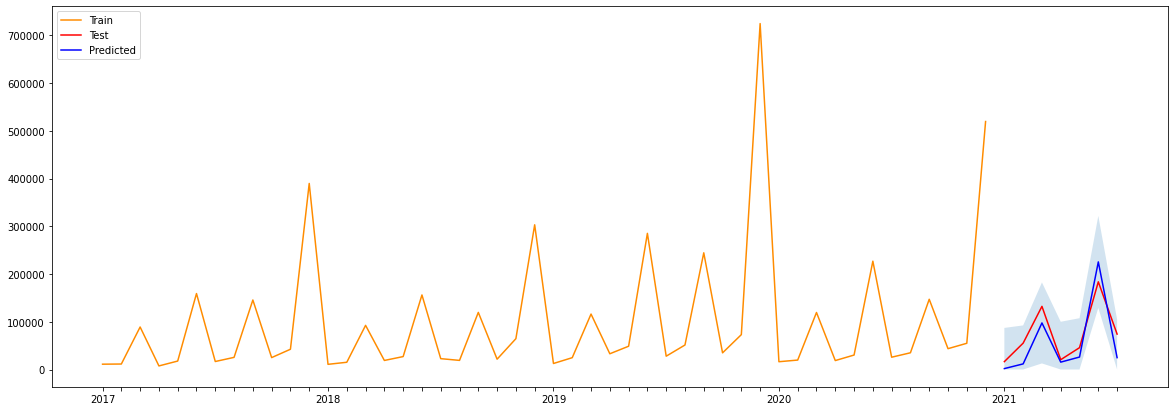

In [29]:
plt.figure(figsize=(20,7))
plt.plot(dates_train, train, color='darkorange', label="Train")
plt.plot(dates_test, test, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()